# Computational Neuroscience Final Project
## Elizabeth Frey

For this project, I used the following resources:
* ChatGPT: See Chat GPT Prompts and Responses Document
* [Keras Model Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)
* [GRU Layer Tutorial](https://pythonalgos.com/2022/01/02/build-a-gru-rnn-in-keras/): Note, I implemented this in the `tutorial.ipynb` file and then used its format as a guideline
* [Skip Thought Vector Libraries and Example](https://pypi.org/project/skip-thoughts/)

In [27]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Data

In [28]:
import pandas as pd
import numpy as np

# read csv file
df = pd.read_csv('data-en-hi-de-fr.csv')

In [29]:
from tensorflow.keras.utils import to_categorical

# create a dictionary of the languages
languages = {'en': 0, 'hi': 1, 'de': 2, 'fr': 3}

# group the dataframe by labels column
grouped = df.groupby('labels')

# create two dataframes, one for ham and one for spam
original_df = df
ham_df = grouped.get_group('ham')
spam_df = grouped.get_group('spam')


def processDf(df):
    df.drop('labels', axis=1, inplace=True)
    df.rename(columns={'text': 'en', 'text_hi': 'hi',
              'text_de': 'de', 'text_fr': 'fr'}, inplace=True)
    df = df.melt(var_name='language', value_name='phrase')
    df['language_code'] = df['language'].map(languages)
    return df


original_df = processDf(original_df)
ham_df = processDf(ham_df)
spam_df = processDf(spam_df)

/var/folders/dm/l18067jn62qb3fkpng93sqhr0000gn/T/ipykernel_94214/3398426871.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('labels', axis=1, inplace=True)
/var/folders/dm/l18067jn62qb3fkpng93sqhr0000gn/T/ipykernel_94214/3398426871.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'text': 'en', 'text_hi': 'hi',
/var/folders/dm/l18067jn62qb3fkpng93sqhr0000gn/T/ipykernel_94214/3398426871.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

## Creating Functions

### Embeddings

In [5]:

# define a function to tokenize the phrases in each dataframe

def tokenizeDf(df):
    tokens = [phrase.split() for phrase in df['phrase']]
    df['tokens'] = tokens
    return df

#### Word2Vec Embeddings

In [6]:
import gensim
from gensim.models import Word2Vec


def addWord2VecEmbeddings(df):
    # train the word2vec model on the ham and spam tokens
    model = Word2Vec(df['tokens'], min_count=1)
    # create the embeddings for each dataframe
    df['w2v_embedding'] = df['tokens'].apply(
        lambda x: model.wv[x].mean(axis=0).astype(np.float32))
    return df

#### Skip-Thought Embeddings

In [ ]:
%%sh
# Directory to download the pretrained models to.
PRETRAINED_MODELS_DIR="./skip_thoughts/pretrained/"

mkdir -p ${PRETRAINED_MODELS_DIR}
cd ${PRETRAINED_MODELS_DIR}

# Download and extract the unidirectional model.
wget "http://download.tensorflow.org/models/skip_thoughts_uni_2017_02_02.tar.gz"
tar -xvf skip_thoughts_uni_2017_02_02.tar.gz
rm skip_thoughts_uni_2017_02_02.tar.gz

# Download and extract the bidirectional model.
wget "http://download.tensorflow.org/models/skip_thoughts_bi_2017_02_16.tar.gz"
tar -xvf skip_thoughts_bi_2017_02_16.tar.gz
rm skip_thoughts_bi_2017_02_16.tar.gz

In [31]:
import skipthoughts


def createSkipThoughtEmbeddings(df):
    model = skipthoughts.load_model()
    encoder = skipthoughts.Encoder(model)
    df['skip_thought_embedding'] = df['tokens'].apply(
        lambda x: encoder.encode(x).astype(np.float32))
    return df

SyntaxError: multiple exception types must be parenthesized (__init__.py, line 149)

### Train the Model

#### Create Training and Testing Data Functions

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

listOfEmbeddings = ['w2v_embedding']

# Create Training and Testing Data Functions


def createTrainingTestingData(embeddingType, df):
    if embeddingType not in listOfEmbeddings:
        print('Invalid embedding type')
        return

    X = df[embeddingType]
    y = df['language_code']

    # create the training and testing dataframes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    y_train_one_hot = to_categorical(y_train, 4)
    y_test_one_hot = to_categorical(y_test, 4)

    # convert the training and testing dataframes to numpy arrays
    X_train = np.array([x for x in X_train])
    X_test = np.array([x for x in X_test])
    y_train = np.array([y for y in y_train_one_hot])
    y_test = np.array([y for y in y_test_one_hot])

    # reshape the training and testing dataframes
    X_train = X_train.reshape(X_train.shape[0], 1, 100)
    X_test = X_test.reshape(X_test.shape[0], 1, 100)

    # Assuming X_train and y_train are NumPy arrays
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    return X_train, X_test, y_train, y_test

#### Create Model Function

In [9]:
from tensorflow import keras
from tensorflow.keras import layers


def createModel():
    model = keras.Sequential()
    model.add(layers.GRU(64, input_shape=(1, 100)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=4, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=["accuracy"],
    )
    return model

#### Fit the Model using Training Data Function

In [10]:
def trainModel(model, X_train, y_train):
    model.fit(
        X_train, y_train, batch_size=64, epochs=10, verbose=2
    )
    return model

### Test the Model

#### Function to print ten random predictions

In [11]:
def printTenPredictions(model, X_test, y_test):
    for i in range(10):
        result = tf.argmax(model.predict(tf.expand_dims(X_test[i], 0)), axis=1)
        print(result.numpy(), y_test[i])

### Evalute the Model

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def evaluateModel(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = tf.argmax(y_test, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=languages.keys(), yticklabels=languages.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Evaluate Model

### Testing Different Embeddings

#### Word2Vec

In [13]:
def word2Vec(df):
    df = tokenizeDf(df)
    df = addWord2VecEmbeddings(df)
    print("\n* Training *")
    X_train, X_test, y_train, y_test = createTrainingTestingData(
        'w2v_embedding', original_df)
    model = createModel()
    model = trainModel(model, X_train, y_train)
    print("\n* Testing *")
    evaluateModel(model, X_test, y_test)

********** Original **********

* Training *
Epoch 1/10
279/279 - 1s - loss: 0.1644 - accuracy: 0.9425 - 1s/epoch - 5ms/step
Epoch 2/10
279/279 - 0s - loss: 0.1083 - accuracy: 0.9623 - 455ms/epoch - 2ms/step
Epoch 3/10
279/279 - 0s - loss: 0.1038 - accuracy: 0.9628 - 369ms/epoch - 1ms/step
Epoch 4/10
279/279 - 0s - loss: 0.0975 - accuracy: 0.9657 - 375ms/epoch - 1ms/step
Epoch 5/10
279/279 - 0s - loss: 0.0956 - accuracy: 0.9663 - 358ms/epoch - 1ms/step
Epoch 6/10
279/279 - 0s - loss: 0.0912 - accuracy: 0.9683 - 338ms/epoch - 1ms/step
Epoch 7/10
279/279 - 0s - loss: 0.0921 - accuracy: 0.9684 - 318ms/epoch - 1ms/step
Epoch 8/10
279/279 - 0s - loss: 0.0917 - accuracy: 0.9693 - 322ms/epoch - 1ms/step
Epoch 9/10
279/279 - 0s - loss: 0.0898 - accuracy: 0.9693 - 319ms/epoch - 1ms/step
Epoch 10/10
279/279 - 0s - loss: 0.0880 - accuracy: 0.9686 - 322ms/epoch - 1ms/step

* Testing *
140/140 [==============================] - 0s 526us/step


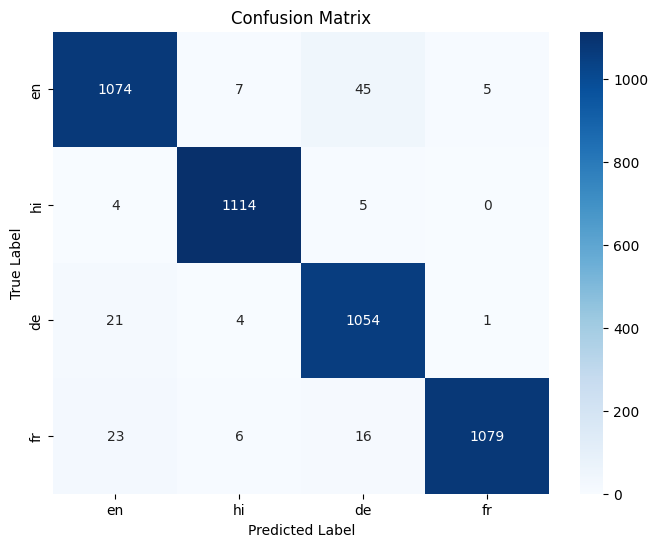

In [14]:
print('********** Original **********')
word2Vec(original_df)

********** Ham **********

* Training *
Epoch 1/10
279/279 - 1s - loss: 0.1755 - accuracy: 0.9445 - 1s/epoch - 4ms/step
Epoch 2/10
279/279 - 0s - loss: 0.1100 - accuracy: 0.9615 - 322ms/epoch - 1ms/step
Epoch 3/10
279/279 - 0s - loss: 0.1041 - accuracy: 0.9626 - 408ms/epoch - 1ms/step
Epoch 4/10
279/279 - 0s - loss: 0.0986 - accuracy: 0.9658 - 348ms/epoch - 1ms/step
Epoch 5/10
279/279 - 0s - loss: 0.0938 - accuracy: 0.9681 - 353ms/epoch - 1ms/step
Epoch 6/10
279/279 - 0s - loss: 0.0959 - accuracy: 0.9661 - 309ms/epoch - 1ms/step
Epoch 7/10
279/279 - 0s - loss: 0.0929 - accuracy: 0.9666 - 310ms/epoch - 1ms/step
Epoch 8/10
279/279 - 0s - loss: 0.0893 - accuracy: 0.9688 - 310ms/epoch - 1ms/step
Epoch 9/10
279/279 - 0s - loss: 0.0912 - accuracy: 0.9677 - 312ms/epoch - 1ms/step
Epoch 10/10
279/279 - 0s - loss: 0.0886 - accuracy: 0.9693 - 316ms/epoch - 1ms/step

* Testing *
140/140 [==============================] - 0s 522us/step


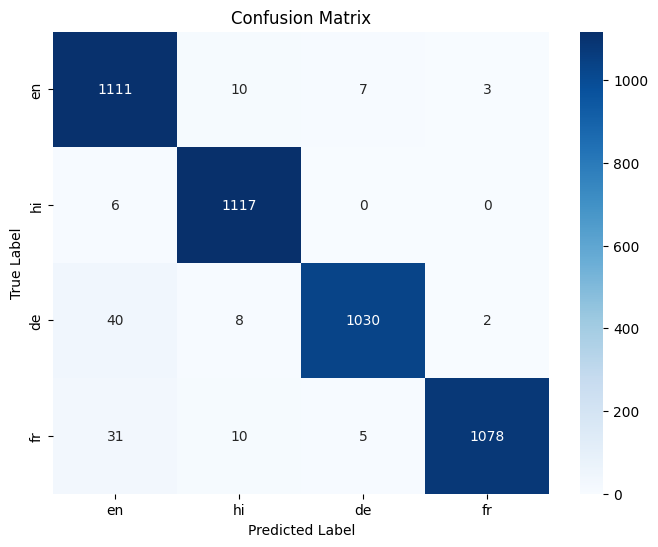

In [15]:
print('********** Ham **********')
word2Vec(ham_df)

********** Spam **********

* Training *
Epoch 1/10
279/279 - 1s - loss: 0.1610 - accuracy: 0.9464 - 1s/epoch - 4ms/step
Epoch 2/10
279/279 - 0s - loss: 0.1085 - accuracy: 0.9600 - 333ms/epoch - 1ms/step
Epoch 3/10
279/279 - 0s - loss: 0.1011 - accuracy: 0.9643 - 329ms/epoch - 1ms/step
Epoch 4/10
279/279 - 0s - loss: 0.0959 - accuracy: 0.9662 - 342ms/epoch - 1ms/step
Epoch 5/10
279/279 - 0s - loss: 0.0946 - accuracy: 0.9670 - 360ms/epoch - 1ms/step
Epoch 6/10
279/279 - 0s - loss: 0.0947 - accuracy: 0.9665 - 346ms/epoch - 1ms/step
Epoch 7/10
279/279 - 0s - loss: 0.0922 - accuracy: 0.9677 - 380ms/epoch - 1ms/step
Epoch 8/10
279/279 - 0s - loss: 0.0904 - accuracy: 0.9673 - 347ms/epoch - 1ms/step
Epoch 9/10
279/279 - 0s - loss: 0.0894 - accuracy: 0.9695 - 360ms/epoch - 1ms/step
Epoch 10/10
279/279 - 0s - loss: 0.0877 - accuracy: 0.9699 - 387ms/epoch - 1ms/step

* Testing *
140/140 [==============================] - 0s 872us/step


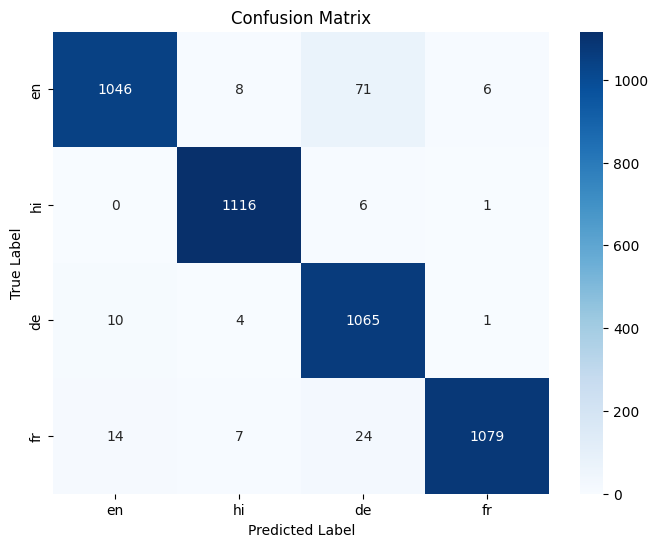

In [16]:
print('********** Spam **********')
word2Vec(spam_df)